# Kaggle challenge first delivery

## Sources

<li>https://www.kaggle.com/spencerpitts/european-hotel-reviews-r</li>
<li>https://www.kaggle.com/gunnvant/what-do-reviews-say</li>
<li>https://www.kaggle.com/code/sampsonsimpson/map-of-hotels-rmd/report</li>
<li>https://www.kaggle.com/code/sampsonsimpson/exploring-515k-european-hotel-reviews/report</li>

## Librairies

In [42]:
#Installer les librairies (Utile seulement la première fois !)
##install.packages("devtools")
#install.packages("RColorBrewer")
#devtools::install_github("hadley/tidyverse")
#install.packages("tidytext")
#install.packages("viridis")  # Installer

#Charger les librairies
library("viridis")           
library(RColorBrewer)
library(tidyverse)
library(lubridate)
library(stringr)
library(forcats)
library(tidytext)
library(sqldf)
library(plotly)
library(leaflet)
library(leaflet.extras)
library(ggplot2)
library(wordcloud2)
library(tm)
################################

library(dplyr)
library(tidyr)
library(leaflet)
library(leaflet.extras)
library(grid)
library(gridExtra)
library(scales)
library(knitr)

## 0 - Présenter dataset

In [43]:
dataset = read.csv("../dataset/Hotel_Reviews.csv")

In [44]:
# check for if any null values are present in which columns
sapply(dataset, function(x)sum(is.na(x)))


Hotel_Address 
                                         0 
              Additional_Number_of_Scoring 
                                         0 
                               Review_Date 
                                         0 
                             Average_Score 
                                         0 
                                Hotel_Name 
                                         0 
                      Reviewer_Nationality 
                                         0 
                           Negative_Review 
                                         0 
         Review_Total_Negative_Word_Counts 
                                         0 
                   Total_Number_of_Reviews 
                                         0 
                           Positive_Review 
                                         0 
         Review_Total_Positive_Word_Counts 
                                         0 
Total_Number_of_Reviews_Reviewer_Has_Given 
                                         0 
                            Reviewer_Score 
                                         0 
                                      Tags 
                                         0 
                         days_since_review 
                                         0 
                                       lat 
                                      3268 
                                       lng 
                                      3268

In [45]:
head(summary(as.factor(dataset$Reviewer_Nationality)), n = 1) # getting top Nationality for na's


United Kingdom  
          245246

## 1 - Nettoyer dataset

In [49]:
# can only run once without getting lat & lng errors!
dataset <- dataset %>%
  select(colnames(dataset), -lat,-lng, -Review_Total_Negative_Word_Counts, -Review_Total_Positive_Word_Counts, -Additional_Number_of_Scoring) %>%
  mutate(Positive_Review = ifelse(is.na(Positive_Review),
                                  "Nothing",
                                  Positive_Review)) %>%
  mutate(Negative_Review = ifelse(is.na(Negative_Review),
                                  "Nothing",
                                  Negative_Review))
sapply(dataset, function(x)sum(is.na(x)))
# good no more NAs!

Hotel_Address 
                                         0 
                               Review_Date 
                                         0 
                             Average_Score 
                                         0 
                                Hotel_Name 
                                         0 
                      Reviewer_Nationality 
                                         0 
                           Negative_Review 
                                         0 
                   Total_Number_of_Reviews 
                                         0 
                           Positive_Review 
                                         0 
Total_Number_of_Reviews_Reviewer_Has_Given 
                                         0 
                            Reviewer_Score 
                                         0 
                                      Tags 
                                         0 
                         days_since_review 
                                         0

In [50]:
dataset <- dataset %>%
  mutate(Review_Date = lubridate::mdy(Review_Date))
#summary(df)
# Time Series Analysis
# is the score dependent on time of year?
dataset <- dataset %>%
  mutate(Year = year(Review_Date)) %>%
  mutate(Month = month(Review_Date))
# credit to fellow kaggle user, GunnvantSaini
dataset <- dataset %>%
  mutate(Country = sapply(str_split(Hotel_Address," "),function(x){x[length(x)]}))

In [51]:
# subsetting out lengthy columns, keeping hotel address and review data if
# needed to join
dataset_nlp <- dataset %>%
  select(Hotel_Name, Country, Review_Date, Year, Month,
         Total_Number_of_Reviews_Reviewer_Has_Given, Negative_Review, Reviewer_Nationality,
         Positive_Review,Total_Number_of_Reviews_Reviewer_Has_Given, Tags, Reviewer_Score)
dataset_clean <- dataset %>%
  select(Hotel_Name, Country, Review_Date, Year, Month, Average_Score,
         Reviewer_Nationality,Reviewer_Score,Total_Number_of_Reviews_Reviewer_Has_Given, Negative_Review,
         Positive_Review)
dataset_clean <- dataset_clean %>%
  mutate(Reviewer_Nationality = trimws(dataset_clean$Reviewer_Nationality, which = "both"))
print("Our dataset cleaned:" )
head(dataset_clean)
print("First column of NLP:" )
head(dataset_nlp, n = 1)

[1] "Our dataset cleaned:"


Hotel_Name  Country     Review_Date Year Month Average_Score
1 Hotel Arena Netherlands 2017-08-03  2017 8     7.7          
2 Hotel Arena Netherlands 2017-08-03  2017 8     7.7          
3 Hotel Arena Netherlands 2017-07-31  2017 7     7.7          
4 Hotel Arena Netherlands 2017-07-31  2017 7     7.7          
5 Hotel Arena Netherlands 2017-07-24  2017 7     7.7          
6 Hotel Arena Netherlands 2017-07-24  2017 7     7.7          
  Reviewer_Nationality Reviewer_Score
1 Russia               2.9           
2 Ireland              7.5           
3 Australia            7.1           
4 United Kingdom       3.8           
5 New Zealand          6.7           
6 Poland               6.7           
  Total_Number_of_Reviews_Reviewer_Has_Given
1 7                                         
2 7                                         
3 9                                         
4 1                                         
5 3                                         
6 1                                         
  Negative_Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
1  I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not the best way to begin your holiday So we had to wait till 13 00 in order to check in my new room what a wonderful waist of my time The r

[1] "First column of NLP:"


Hotel_Name  Country     Review_Date Year Month
1 Hotel Arena Netherlands 2017-08-03  2017 8    
  Total_Number_of_Reviews_Reviewer_Has_Given
1 7                                         
  Negative_Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
1  I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not the best way to begin your holiday So we had to wait till 13 00 in order to check in my new room what a wonderful waist of my time The room 023 i got was just as i wanted to peaceful internal garden view big window We were tired from waiting the room so we placed our belongings and rushed to the city In the evening it turned out that there was a constant noise in the room i guess it was made by vibrating vent tubes or something it was constant and annoying as hell AND it did not stop even at 2 am making it hard to fall asleep for me and my wife I have an audio recording that i can not attach here but if you want i can send it via e mail The next day the technician came but was not able to determine the cause of the disturbing sound so i was offered to change the room once again the hotel was fully booked and they had only 1 room left the one that was smaller but seems newer 
  Reviewer_Nationality Positive_Review                                   
1  Russi

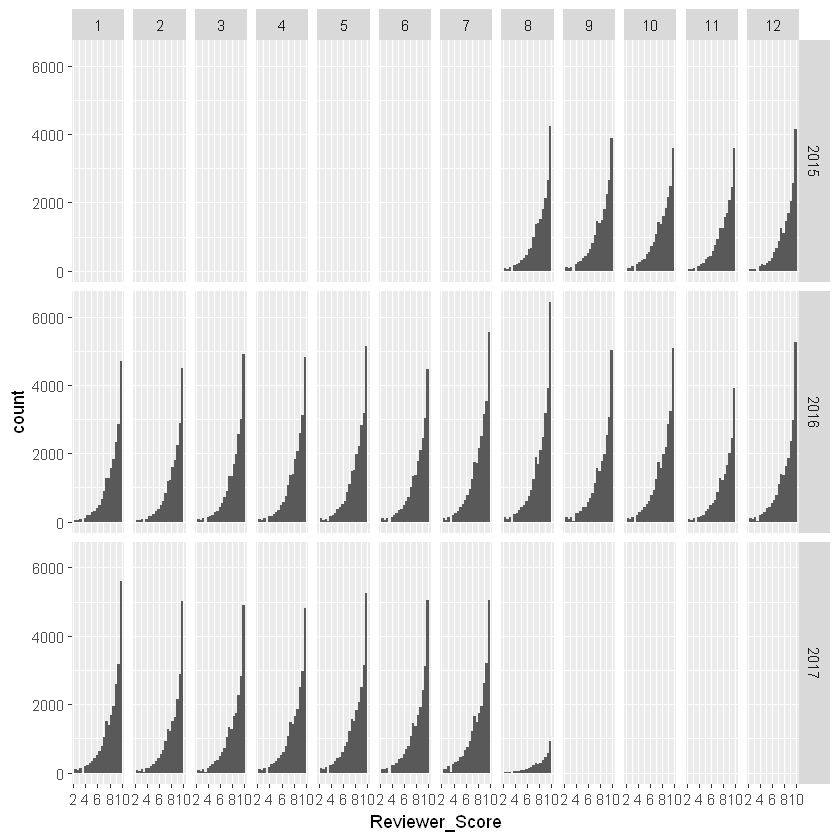

In [52]:
#date non utile car par autant de données dans chaque année
df_eda <- dataset_clean %>%
    select(Hotel_Name, Country, Review_Date, Year, Month, Average_Score,
    Reviewer_Nationality,Reviewer_Score,Total_Number_of_Reviews_Reviewer_Has_Given)

ggplot(df_eda, aes(Reviewer_Score)) +
  geom_histogram(bins = 20) + 
  facet_grid(Year~Month)

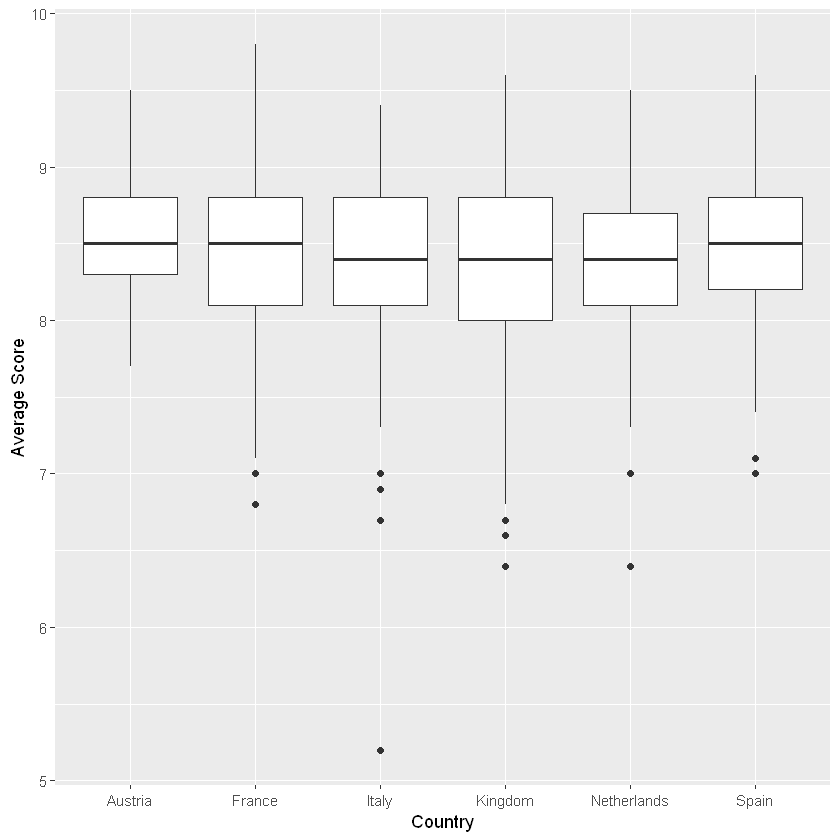

In [53]:
dataset_clean%>%ggplot(aes(x=as.factor(Country),y=Average_Score))+geom_boxplot()+xlab("Country")+ylab("Average Score")

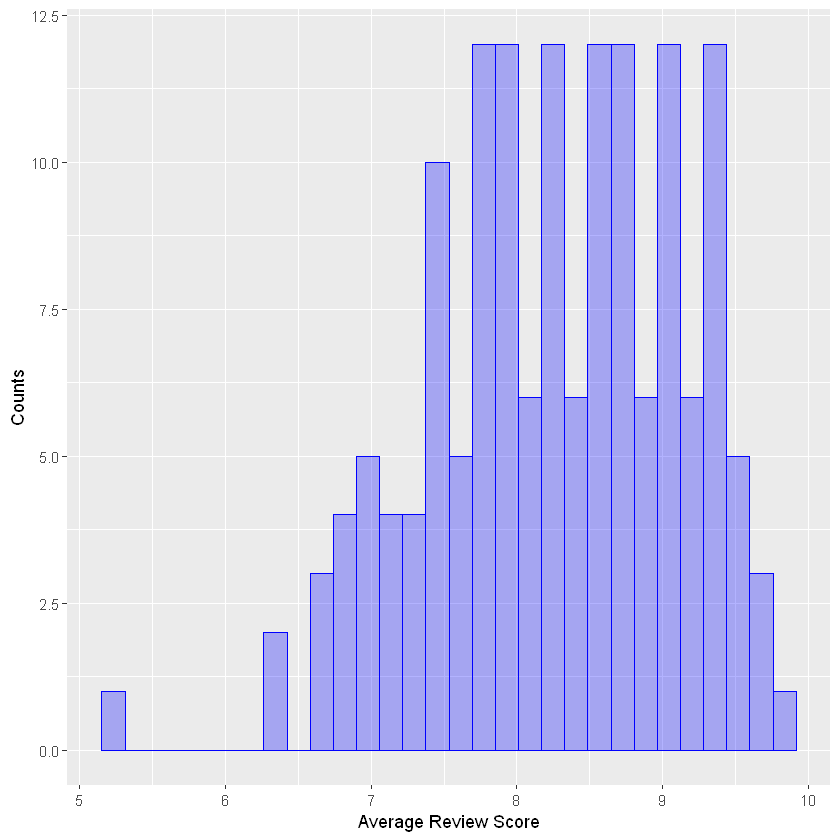

In [54]:
dataset_clean%>%select(Average_Score,Country)%>%distinct(Average_Score,Country)%>%ggplot(aes(x=Average_Score))+geom_histogram(color='blue',fill='blue',alpha=0.3,bins=30)+xlab("Average Review Score")+ylab("Counts")

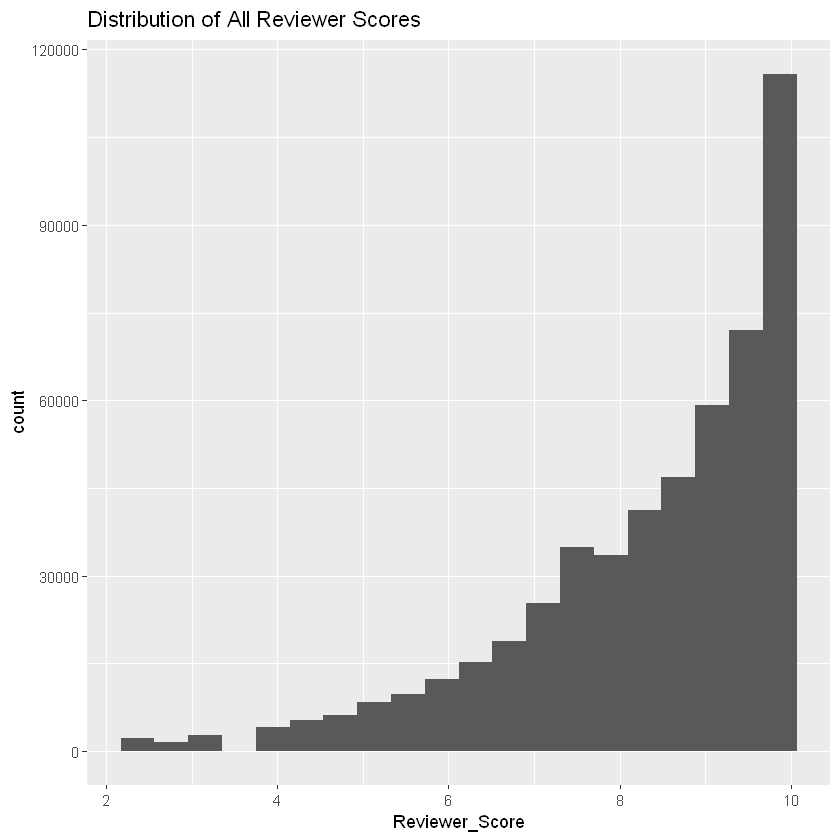

In [55]:
ggplot(dataset_clean, aes(Reviewer_Score))+
  geom_histogram(bins = 20) +
  ggtitle("Distribution of All Reviewer Scores")

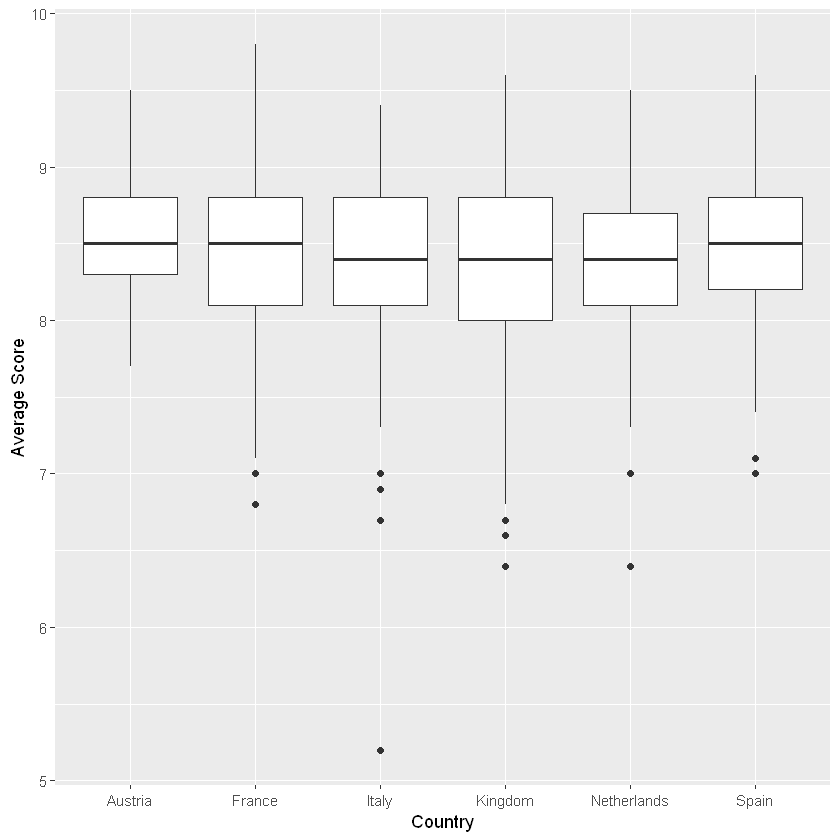

In [56]:
dataset%>%ggplot(aes(x=as.factor(Country),y=Average_Score))+geom_boxplot()+xlab("Country")+ylab("Average Score")

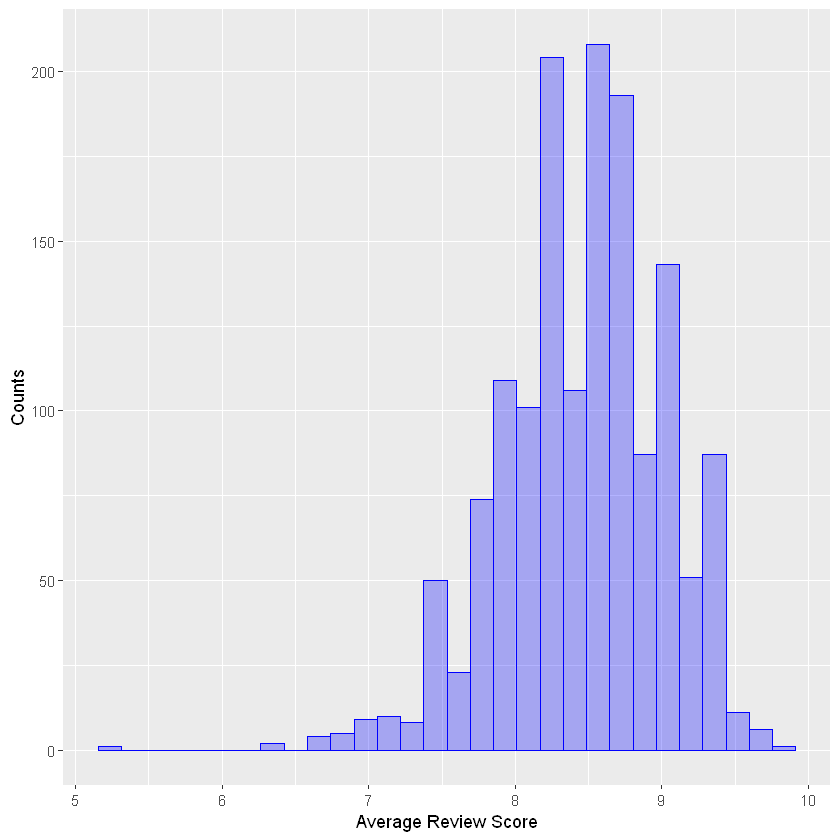

In [57]:
dataset_clean%>%select(Average_Score,Hotel_Name)%>%distinct(Average_Score,Hotel_Name)%>%ggplot(aes(x=Average_Score))+geom_histogram(color='blue',fill='blue',alpha=0.3,bins=30)+xlab("Average Review Score")+ylab("Counts")

## 2- Hotels

In [58]:
# re-importing the dataset because we need different threatment of the data
dataset_f <- read.csv('../dataset/Hotel_Reviews.csv')

In [59]:
# Function to extract country from lat/lon (will be switching to getting name from address field)

# from:https://stackoverflow.com/a/14342127
#install.packages("sp")
#install.packages("rworldmap")
library(sp)
library(rworldmap)

# The single argument to this function, points, is a data.frame in which:
#   - column 1 contains the longitude in degrees
#   - column 2 contains the latitude in degrees
coords2country <- function(points) {
    countriesSP <- getMap(resolution = "low")
    # countriesSP <- getMap(resolution='high') #you could use high res map from rworldxtra if you were concerned about detail

    # convert our list of points to a SpatialPoints object

    # pointsSP = SpatialPoints(points, proj4string=CRS(" +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs +towgs84=0,0,0"))

    # setting CRS directly to that from rworldmap
    pointsSP <- SpatialPoints(points, proj4string = CRS(proj4string(countriesSP)))


    # use 'over' to get indices of the Polygons object containing each point
    indices <- over(pointsSP, countriesSP)

    # return the ADMIN names of each country
    indices$ADMIN
    # indices$ISO3 # returns the ISO3 code
    # indices$continent   # returns the continent (6 continent model)
    # indices$REGION   # returns the continent (7 continent model)
}

In [60]:
dataset_f$Review_Range <- cut(dataset_f$Reviewer_Score, breaks = 1.5:11, include.lowest = T)
dataset_f$lng[is.na(dataset_f$lng)] <- 0
dataset_f$lat[is.na(dataset_f$lat)] <- 0
dataset_f$Country <- coords2country(cbind(dataset_f$lng, dataset_f$lat))
dataset_f$Total_Words <- dataset_f$Review_Total_Negative_Word_Counts + dataset_f$Review_Total_Positive_Word_Counts
dataset_f$Positive_Word_Rate <- dataset_f$Review_Total_Positive_Word_Counts / dataset_f$Total_Words

dataset_f$Review_Range <- as.factor(cut(dataset_f$Reviewer_Score, breaks = 1.5:11, include.lowest = T))
dataset_f$Review_Range <- gsub("]", ")", dataset_f$Review_Range)
dataset_f$Review_Range <- factor(dataset_f$Review_Range, levels = c(
    "(9.5,10.5)", "(8.5,9.5)",
    "(7.5,8.5)", "(6.5,7.5)",
    "(5.5,6.5)", "(4.5,5.5)",
    "(3.5,4.5)", "(2.5,3.5)",
    "[1.5,2.5)"
))

In [61]:
review_range <- dataset_f %>%
    select(
        Review_Range, Total_Number_of_Reviews,
        Review_Total_Positive_Word_Counts, Review_Total_Negative_Word_Counts, Hotel_Name
    ) %>%
    # #Remove the 17 records without geo coordinates
    # filter(lat != 0 & lng != 0) %>%
    group_by(Review_Range) %>%
    summarise(
        Tot_Pos_Words = sum(Review_Total_Positive_Word_Counts),
        Tot_Neg_Words = sum(Review_Total_Negative_Word_Counts),
        Total_Words = sum(Tot_Pos_Words + Tot_Neg_Words),
        Pos_Word_Rate = percent(Tot_Pos_Words / Total_Words),
        Neg_Word_Rate = percent(Tot_Neg_Words / Total_Words),
        Num_Reviews = n(),
        Avg_Words_Per_Review = format(Total_Words / Num_Reviews, digits = 4)
    )

kable(as.data.frame(review_range))



|Review_Range | Tot_Pos_Words| Tot_Neg_Words| Total_Words|Pos_Word_Rate |Neg_Word_Rate | Num_Reviews|Avg_Words_Per_Review |
|:------------|-------------:|-------------:|-----------:|:-------------|:-------------|-----------:|:--------------------|
|(9.5,10.5)   |       4225446|       1522605|     5748051|74%           |26%           |      187020|30.73                |
|(8.5,9.5)    |       2103694|       1620338|     3724032|56%           |44%           |      106446|34.99                |
|(7.5,8.5)    |       1232517|       1471274|     2703791|46%           |54%           |       75277|35.92                |
|(6.5,7.5)    |        998241|       2088555|     3086796|32%           |68%           |       78966|39.09                |
|(5.5,6.5)    |        280053|       1040287|     1320340|21%           |79%           |       27573|47.89                |
|(4.5,5.5)    |        205206|       1038447|     1243653|17%           |83%           |       24415|50.94                |
|(3.5,

In [62]:
p1 <- ggplot(review_range, aes(
    x = Review_Range,
    y = Num_Reviews,
    fill = Review_Range
)) +
    geom_bar(stat = "identity", alpha = 0.7) +
    geom_text(label = review_range$Num_Reviews, nudge_y = 0.5) +
    ggtitle(label = "Number of Reviews by Range of Score") +
    labs(xlab("Review Range"), ylab("Number of Reviews")) +
    theme(legend.position = "off")

g1 <- ggplotGrob(p1)

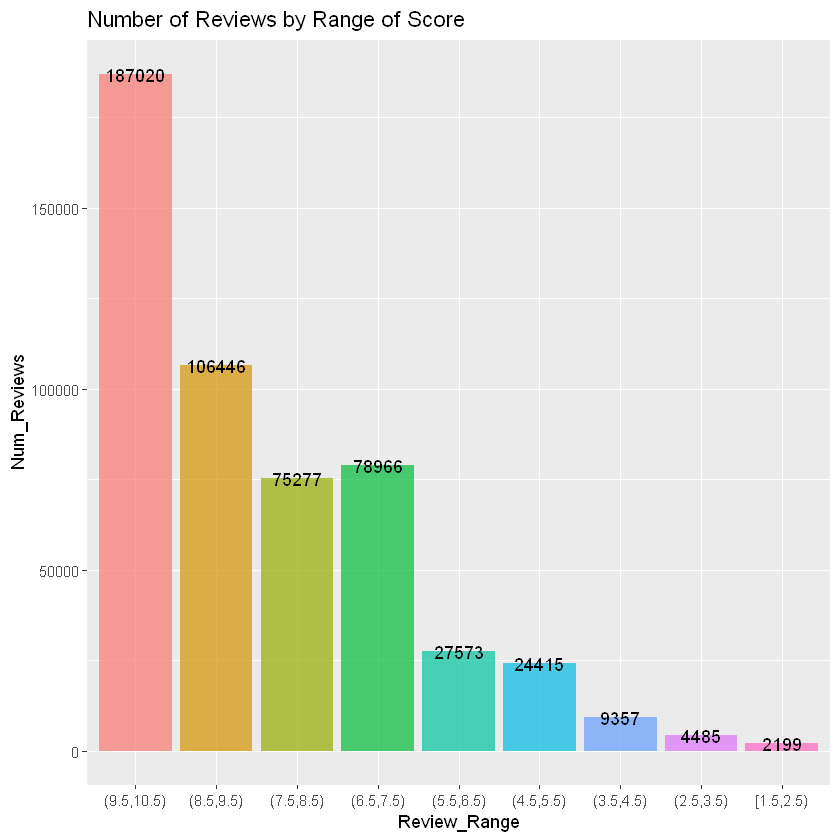

In [63]:
grid.draw(g1)

In [64]:
p2 <- ggplot(review_range, aes(
    x = Review_Range,
    y = Pos_Word_Rate,
    fill = Review_Range
)) +
    geom_bar(stat = "identity", alpha = 0.7) +
    geom_text(label = review_range$Pos_Word_Rate, nudge_y = 0.2) +
    ggtitle(label = "Percent Positive Words by Range of Score") +
    labs(xlab("Review Range"), ylab("Percent(%) Positive Words")) +
    theme(legend.position = "bottom")

g2 <- ggplotGrob(p2)

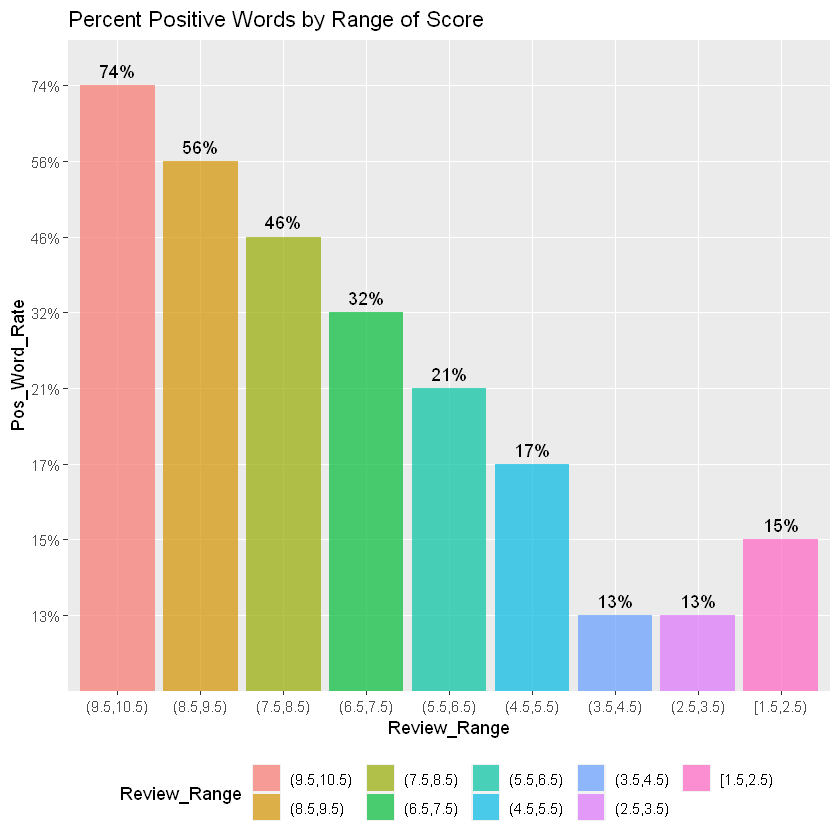

In [65]:
grid.draw(g2)

In [66]:
p3 <- ggplot(review_range, aes(
    x = Review_Range,
    y = Avg_Words_Per_Review,
    fill = Review_Range
)) +
    geom_bar(stat = "identity", alpha = 0.7) +
    geom_text(label = review_range$Avg_Words_Per_Review, nudge_y = 0.2) +
    ggtitle(label = "Average Words per Review by Range of Score") +
    labs(xlab("Review Range"), ylab("Avg. Words per Review")) +
    theme(legend.position = "off")

g3 <- ggplotGrob(p3)


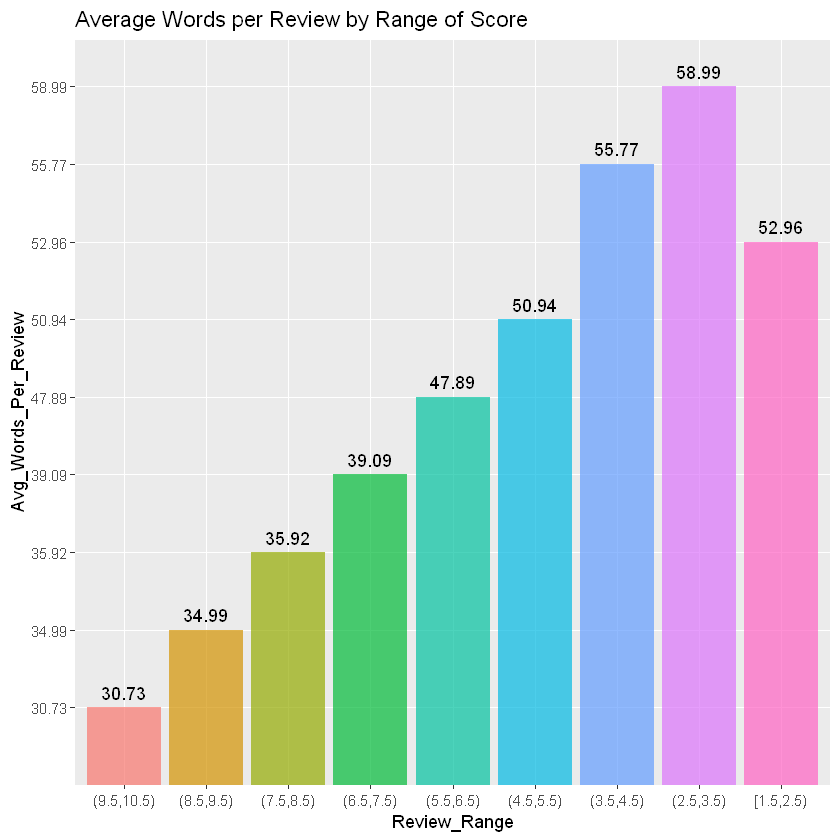

In [67]:
grid.draw(g3)

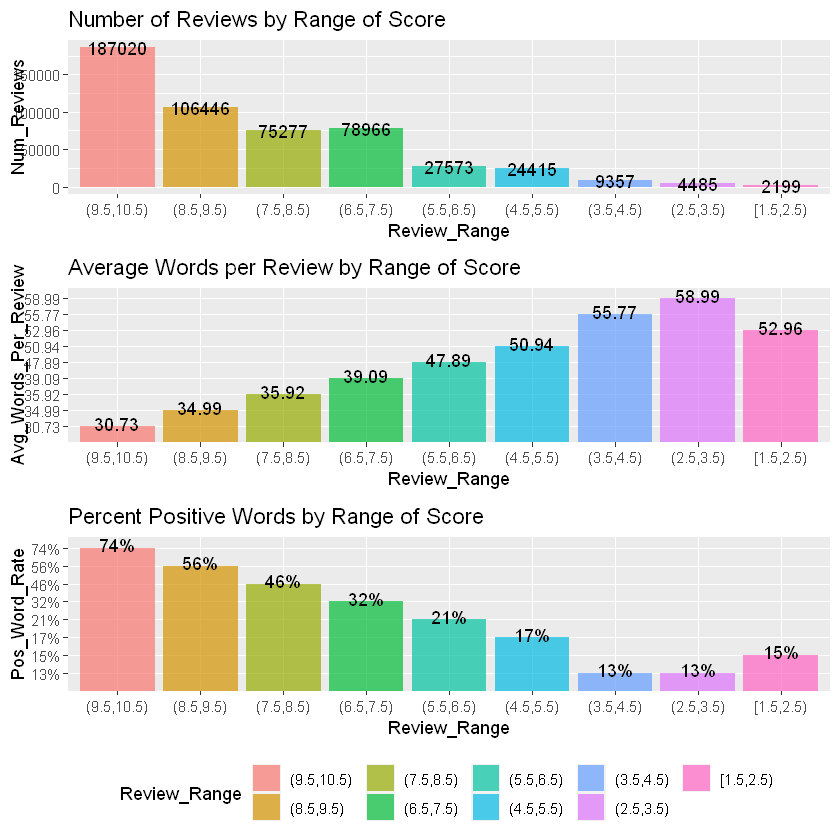

In [68]:
grid.draw(rbind(g1, g3, g2, size = "last"))

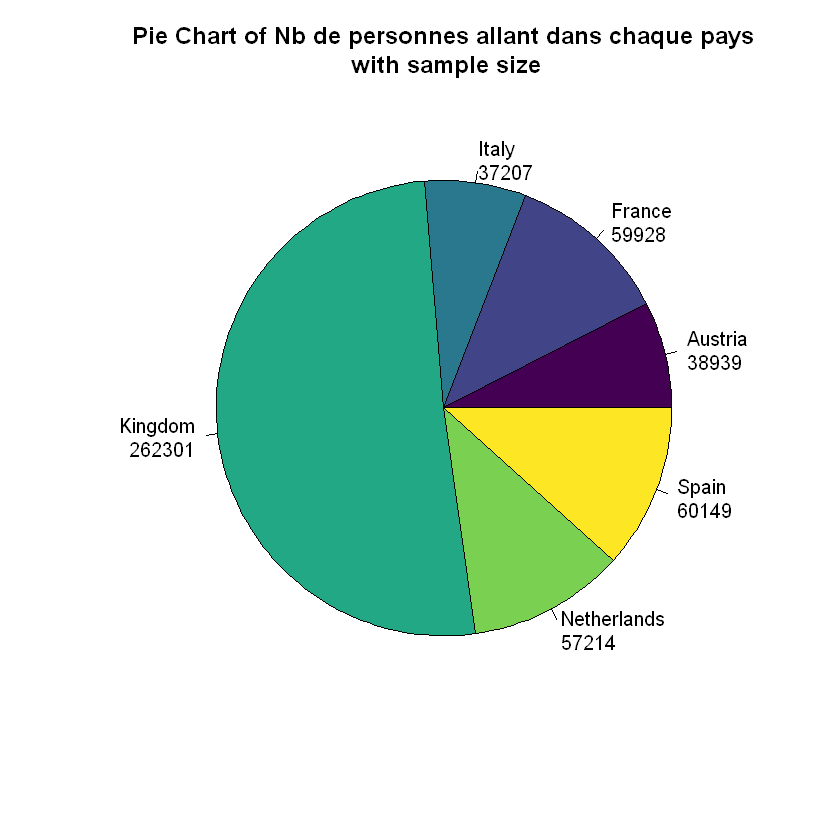

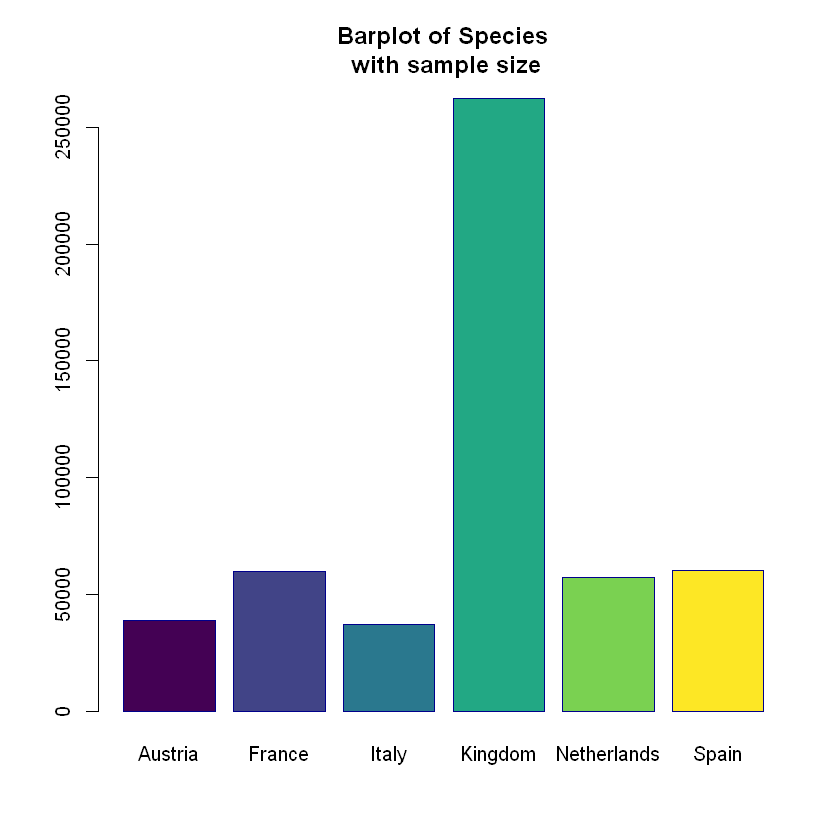

In [69]:
#PIECHART

countryTable <- table(dataset_clean$Country)
pieNames <- paste(countryTable, sep="")
pieLabels <- paste(names(countryTable), "\n", countryTable, sep="")
pie(countryTable, labels = pieLabels, col = viridis(length(countryTable)),
    main="Pie Chart of Nb de personnes allant dans chaque pays\n with sample size")

#Barplot 
barplot(countryTable, 
        col = viridis(length(countryTable)),
        border = "dark blue"
        )
title(main = "Barplot of Species\n with sample size")

## 3- Reviewer

HTML widgets cannot be represented in plain text (need html)

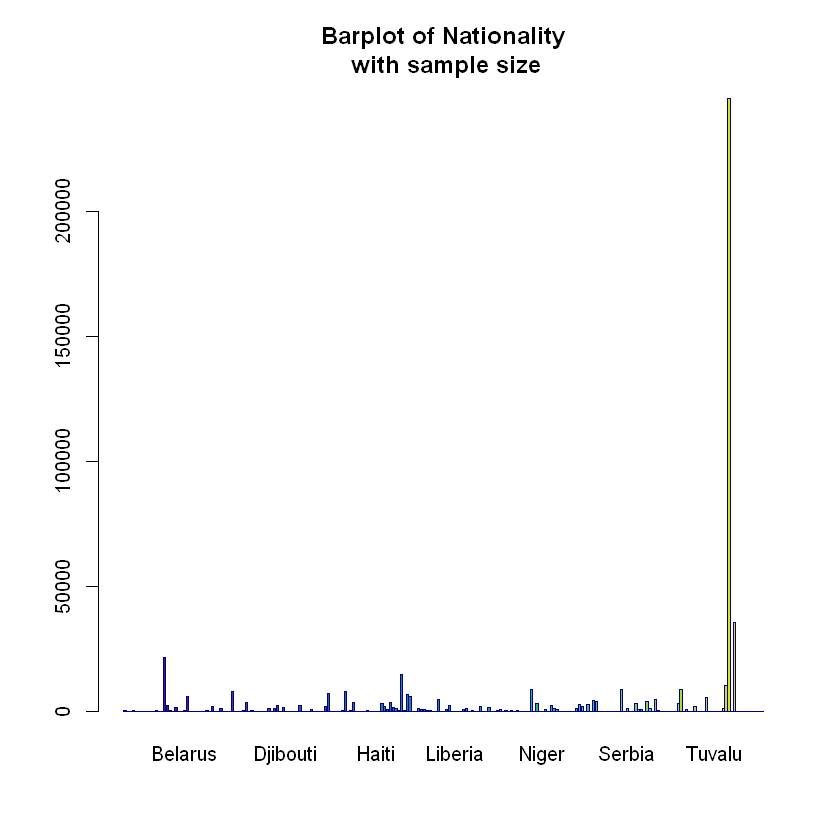

In [40]:
#PIECHART
nationalityTable <- table(dataset$Reviewer_Nationality)
pieNames <- paste(nationalityTable, sep="")
pieLabels <- paste(names(nationalityTable), "\n", nationalityTable, sep="")
#pie(nationalityTable, labels = pieLabels, main="Pie Chart of Nationality\n with sample size")

#Barplot 
barplot(nationalityTable,
        col = viridis(length(nationalityTable)),
        border = "dark blue"
       )
title(main = "Barplot of Nationality\n with sample size")

wordcloud2(data = nationalityTable, minRotation = 0, maxRotation = 45)


    No    Yes 
507984   7754 

`summarise()` has grouped output by 'Country'. You can override using the `.groups` argument.


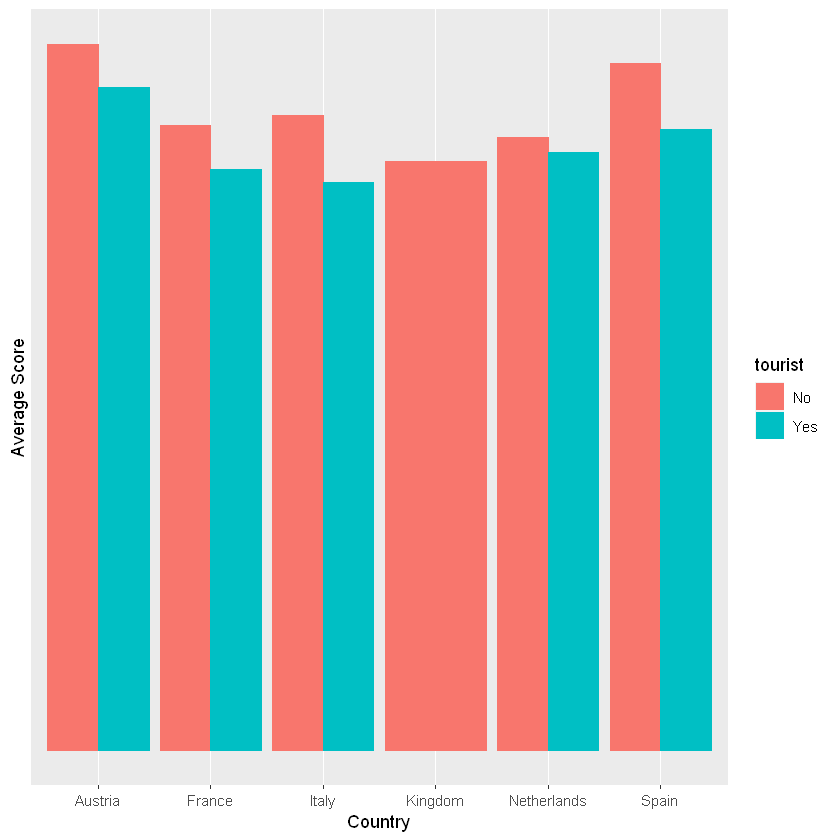

In [20]:
#ind=which(is.na(dataset_clean$Reviewer_Nationality))
#data_model=dataset_clean[-ind,]"""

dataset_clean$tourist=ifelse(dataset_clean$Reviewer_Nationality==dataset_clean$Country,"Yes","No")
dataset_clean$tourist=as.factor(dataset_clean$tourist)
table(dataset_clean$tourist)
dataset_clean%>%group_by(Country,tourist)%>%summarise(average_score=mean(Average_Score))%>%ungroup()%>%mutate(Average_Score=average_score**7)%>%ggplot(aes(x=Country,y=Average_Score,color=tourist,fill=tourist))+geom_bar(stat='identity',position='dodge')+xlab("Country")+ylab("Average Score")+scale_y_continuous(breaks = NULL)



    No    Yes 
507984   7754 

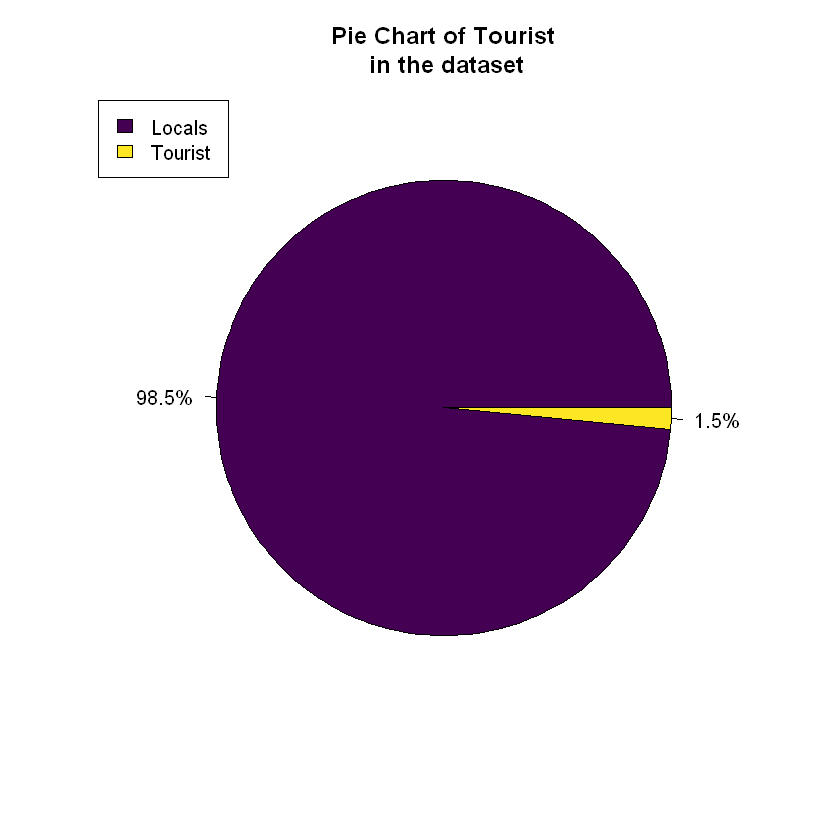

In [21]:
touristTable <- table(dataset_clean$tourist)
touristTable
#pieNames <- paste(touristTable, sep="")
pieLabels <- paste0(round(100 * touristTable/sum(touristTable), 2), "%")
pie(touristTable, labels = pieLabels, col = viridis(length(touristTable)),
    main="Pie Chart of Tourist\n in the dataset")

legend("topleft", legend = c("Locals", "Tourist"),
       fill =  viridis(length(touristTable)))

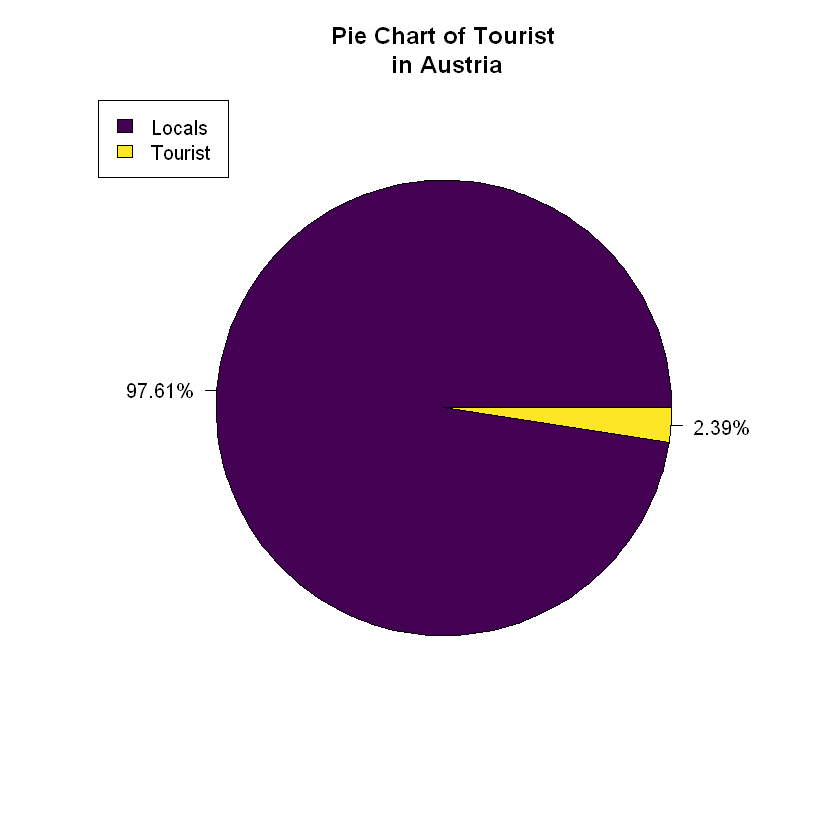

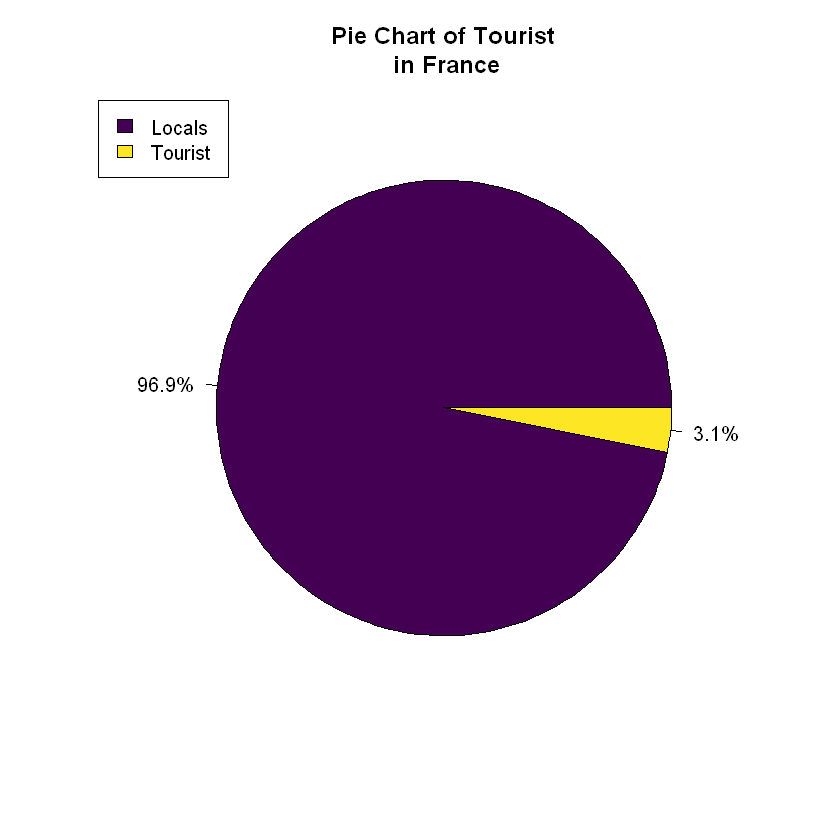

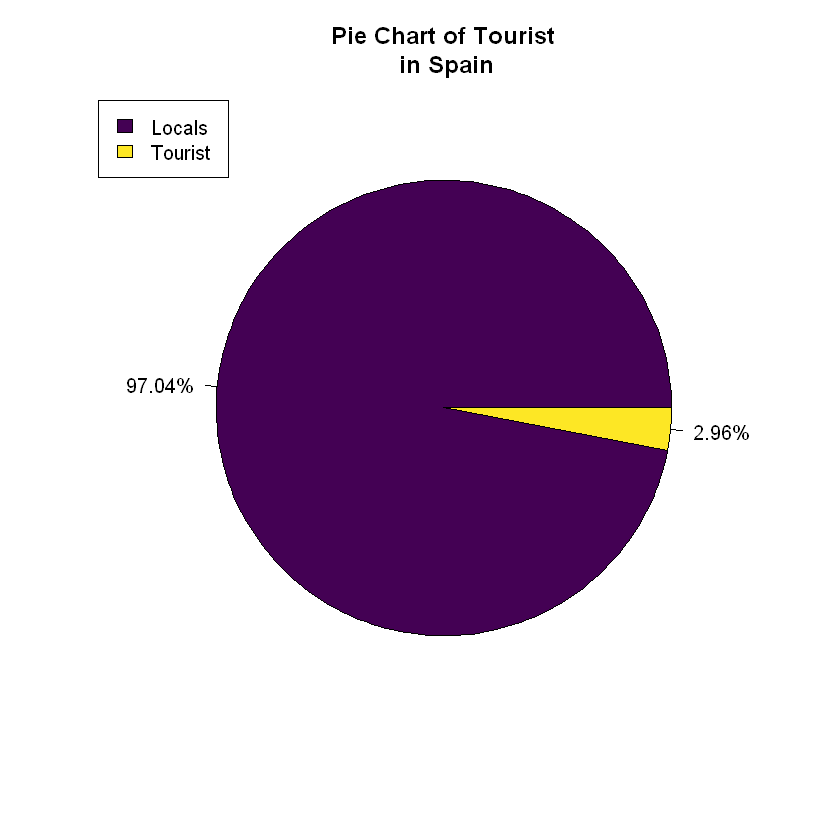

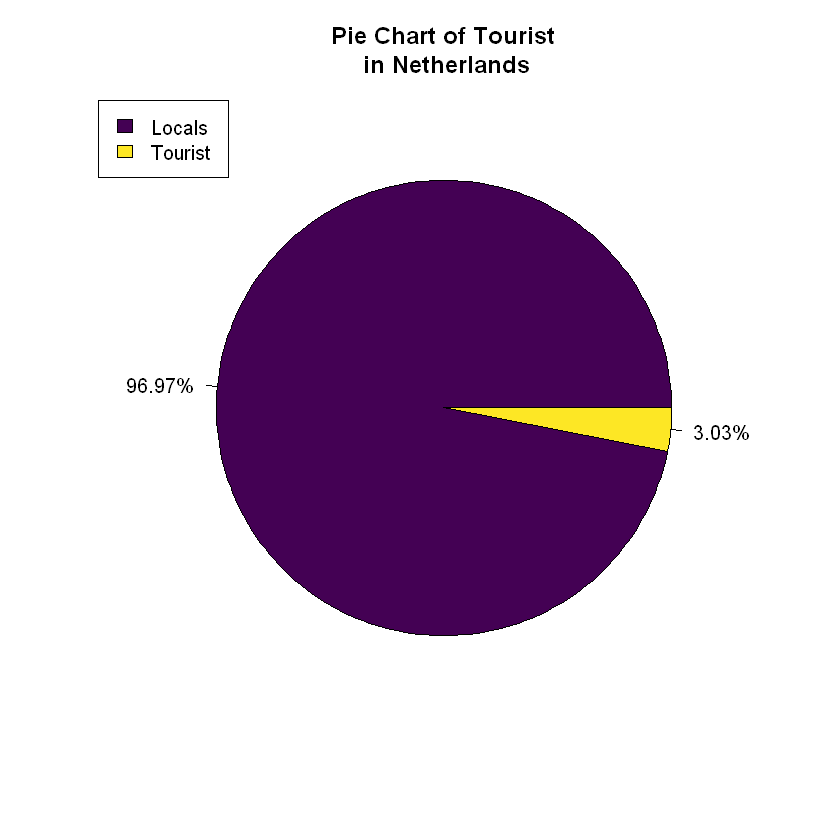

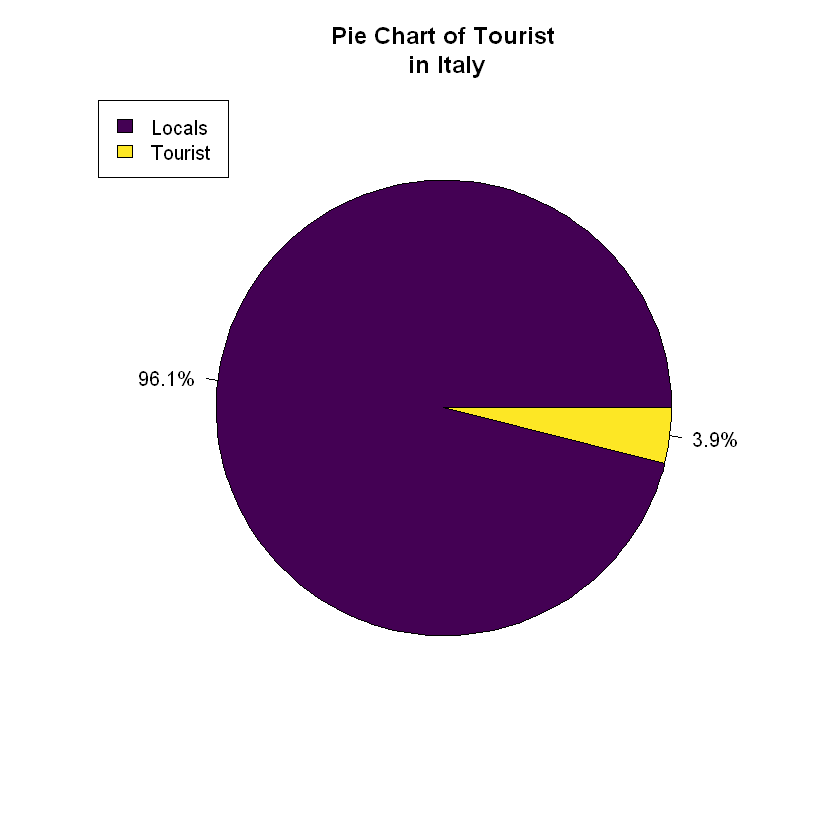

In [41]:
atTable <- table(((dataset_clean%>%filter(Country=='Austria'))$tourist))
pieLabels <- paste0(round(100 * atTable/sum(atTable), 2), "%")
pie(atTable, labels = pieLabels, col = viridis(length(atTable)),
    main="Pie Chart of Tourist\n in Austria") -> at

legend("topleft", legend = c("Locals", "Tourist"),
       fill =  viridis(length(atTable)))


frTable <- table(((dataset_clean%>%filter(Country=='France'))$tourist))
pieLabels <- paste0(round(100 * frTable/sum(frTable), 2), "%")
pie(frTable, labels = pieLabels, col = viridis(length(atTable)),
    main="Pie Chart of Tourist\n in France") -> fr

legend("topleft", legend = c("Locals", "Tourist"),
       fill =  viridis(length(atTable)))


spTable <- table(((dataset_clean%>%filter(Country=='Spain'))$tourist))
pieLabels <- paste0(round(100 * spTable/sum(spTable), 2), "%")
pie(spTable, labels = pieLabels, col = viridis(length(atTable)),
    main="Pie Chart of Tourist\n in Spain")

legend("topleft", legend = c("Locals", "Tourist"),
       fill =  viridis(length(atTable)))

nTable <- table(((dataset_clean%>%filter(Country=='Netherlands'))$tourist))
pieLabels <- paste0(round(100 * nTable/sum(nTable), 2), "%")
pie(nTable, labels = pieLabels, col = viridis(length(atTable)),
    main="Pie Chart of Tourist\n in Netherlands")

legend("topleft", legend = c("Locals", "Tourist"),
       fill =  viridis(length(atTable)))


itTable <- table(((dataset_clean%>%filter(Country=='Italy'))$tourist))
pieLabels <- paste0(round(100 * itTable/sum(itTable), 2), "%")
pie(itTable, labels = pieLabels, col = viridis(length(atTable)),
    main="Pie Chart of Tourist\n in Italy")

legend("topleft", legend = c("Locals", "Tourist"),
       fill =  viridis(length(atTable)))


#grid.arrange(at,fr,ncol=2)

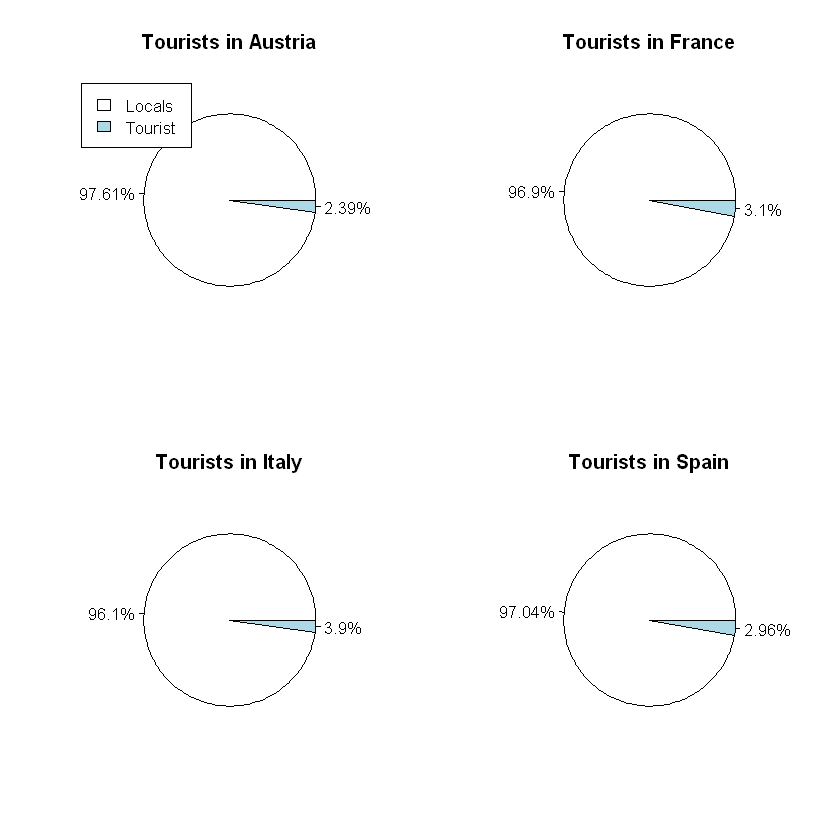

In [23]:
# set the plotting area into a 1*2 array
par(mfrow=c(2,2))

# Draw the two pie chart using above datasets
pie(atTable, paste0(round(100 * atTable/sum(atTable), 2), "%"),main="Tourists in Austria")
legend("topleft", legend = c("Locals", "Tourist"),
       fill =  c("white", "lightblue"))

pie(frTable, paste0(round(100 * frTable/sum(frTable), 2), "%"),main="Tourists in France")
pie(atTable, paste0(round(100 * itTable/sum(itTable), 2), "%"),main="Tourists in Italy")
pie(spTable, paste0(round(100 * spTable/sum(spTable), 2), "%"),main="Tourists in Spain")



## 4 - Synthèse

?

# Brouillons

In [11]:

#plot_world_cloud
reviews <- dataset_clean[sample(nrow(dataset_clean), 40000), ]
reviews <- reviews[reviews$Positive_Review!='Nothing',]
reviews <- reviews[reviews$Negative_Review!='Nothing',]
term_freq <- function(dataset_clean,sent){
  if(sent=='pos'){
    corpus <- Corpus(VectorSource(dataset_clean$Positive_Review))
  }else{
    corpus <- Corpus(VectorSource(dataset_clean$Negative_Review))
  }
  corpus <- tm_map(corpus, removeWords, stopwords("SMART"))
  corpus <- tm_map(corpus, removeWords, stopwords("en"))
  corpus <- tm_map(corpus, stripWhitespace)
  dtm <-TermDocumentMatrix(corpus)
  mat_dtm <- as.matrix(dtm)
  v_dtm <- sort(rowSums(mat_dtm),decreasing = TRUE)
  FreqMat <- data.frame(word = names(v_dtm), Freq = v_dtm)
  FreqMat <- FreqMat[1:50,]
  return(FreqMat)
}

In [12]:
wordcloud2(data = term_freq(reviews,'neg'), minRotation = 0, maxRotation = 0)

Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("SMART")):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("en")):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
"transformation drops documents"


HTML widgets cannot be represented in plain text (need html)

In [13]:
dataset_country <- dataset %>%
  select(Hotel_Name, Country, Review_Date, Year, Month,
         Total_Number_of_Reviews_Reviewer_Has_Given, Negative_Review, Reviewer_Nationality,
         Positive_Review,Total_Number_of_Reviews_Reviewer_Has_Given, Tags, Reviewer_Score)
data = subset(dataset_country, Country == c("Austria"))
#plot_world_cloud
reviews <- data[sample(nrow(data), 4000), ]
reviews <- reviews[reviews$Positive_Review!='Nothing',]
reviews <- reviews[reviews$Negative_Review!='Nothing',]
term_freq <- function(data,sent){
  if(sent=='pos'){
    corpus <- Corpus(VectorSource(data$Positive_Review))
  }else{
    corpus <- Corpus(VectorSource(data$Negative_Review))
  }
  corpus <- tm_map(corpus, removeWords, stopwords("SMART"))
  corpus <- tm_map(corpus, removeWords, stopwords("en"))
  corpus <- tm_map(corpus, stripWhitespace)
  dtm <-TermDocumentMatrix(corpus)
  mat_dtm <- as.matrix(dtm)
  v_dtm <- sort(rowSums(mat_dtm),decreasing = TRUE)
  FreqMat <- data.frame(word = names(v_dtm), Freq = v_dtm)
  FreqMat <- FreqMat[1:50,]
  return(FreqMat)
}
wordcloud2(data = term_freq(reviews,'pos'),minRotation = 0,maxRotation = 0)

Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("SMART")):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("en")):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
"transformation drops documents"


HTML widgets cannot be represented in plain text (need html)

# Partie Floriane

Toutes les nationalités -> Valeurs trop inégales pour être lisibles
(Trouver un graphique plus adapté ?)
(Laisser pour montrer que ce pays a plus répondu au sondage que les autres ?)

In [17]:
#WorkCloud

dataset_country <- dataset %>%
  select(Hotel_Name, Country, Review_Date, Year, Month,
         Total_Number_of_Reviews_Reviewer_Has_Given, Negative_Review, Reviewer_Nationality,
         Positive_Review,Total_Number_of_Reviews_Reviewer_Has_Given, Tags, Reviewer_Score)
#plot_world_cloud
reviews <- dataset_clean[sample(nrow(data), 4000), ]

term_freqNat <- function(dataset){
    corpus <- Corpus(VectorSource(dataset$Reviewer_Nationality))
    corpus <- tm_map(corpus, removeWords, stopwords("SMART"))
    corpus <- tm_map(corpus, removeWords, stopwords("en"))
    corpus <- tm_map(corpus, stripWhitespace)
    dtm <-TermDocumentMatrix(corpus)
    mat_dtm <- as.matrix(dtm)
    v_dtm <- sort(rowSums(mat_dtm),decreasing = TRUE)
    FreqMat <- data.frame(word = names(v_dtm), Freq = v_dtm)
    FreqMat <- FreqMat[1:50,]
    return(FreqMat)
}
wordcloud2(data = term_freqNat(reviews), minRotation = 0, maxRotation = 45)

HTML widgets cannot be represented in plain text (need html)

Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("SMART")):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("en")):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
"transformation drops documents"


HTML widgets cannot be represented in plain text (need html)

Tous les pays -> Représenter seulement une valeur par hôtel, et non par reviewer

In [19]:
#dataset_country = dataset_clean[0:2]
#print(dataset_country)

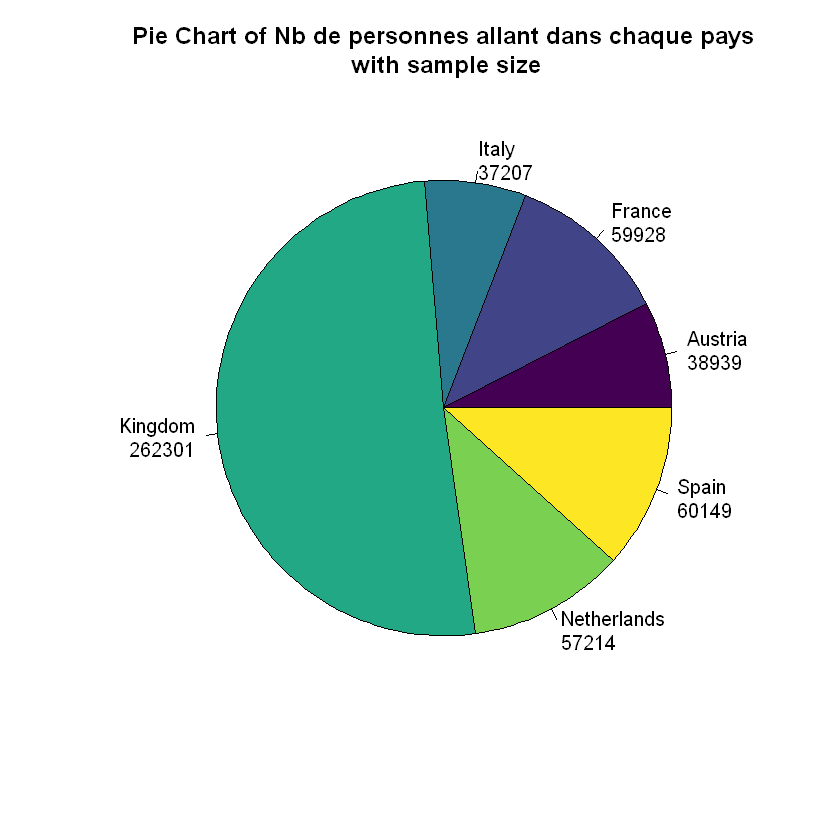

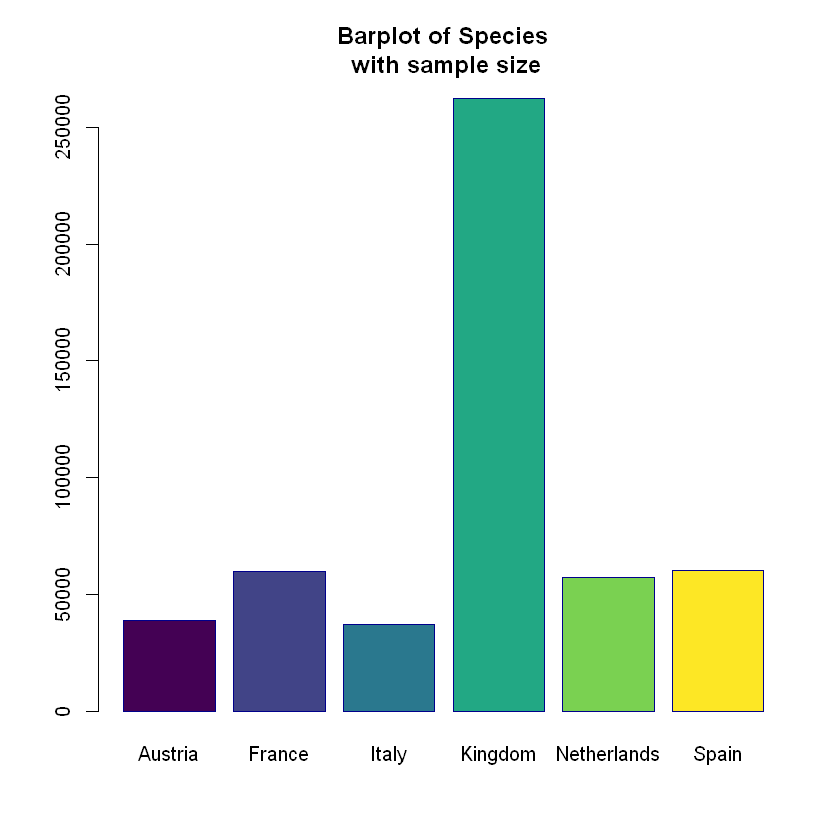

In [18]:
#PIECHART

countryTable <- table(dataset_clean$Country)
pieNames <- paste(countryTable, sep="")
pieLabels <- paste(names(countryTable), "\n", countryTable, sep="")
pie(countryTable, labels = pieLabels, col = viridis(length(countryTable)),
    main="Pie Chart of Nb de personnes allant dans chaque pays\n with sample size")

#Barplot 
barplot(countryTable, 
        col = viridis(length(countryTable)),
        border = "dark blue"
        )
title(main = "Barplot of Species\n with sample size")

In [19]:
## Get hotel details
dataset_clean <- 
    select(Hotel_Name,lat,lng,Hotel_Address)%>%group_by(Hotel_Address) <- 
        filter(!duplicated(Hotel_Address))->hotel_details
hotel_details$country=sapply(str_split(hotel_details$Hotel_Address," "),function(x){x[length(x)]})
hotel_details$city=sapply(str_split(hotel_details$Hotel_Address," "),function(x){x[length(x)-1]})
## Remove the mention of "United" as "London" in the city column and "Kingdom" as "United Kingdom" in the country column
hotel_details$city=str_replace(hotel_details$city,"United","London")
hotel_details$country=str_replace(hotel_details$country,"Kingdom","United Kingdom")
data%>%left_join(hotel_details[,4:6],by = 'Hotel_Address')->data
countries=paste(unique(hotel_details$country),collapse=",")
message=paste("The countries mentioned in the dataset are:", countries)
print(message)

ERROR: Error in duplicated(Hotel_Address): objet 'Hotel_Address' introuvable


Proportion de touristes/Locaux

# AbQ

In [24]:
# https://www.kaggle.com/code/sampsonsimpson/map-of-hotels-rmd/report
# https://www.kaggle.com/code/sampsonsimpson/exploring-515k-european-hotel-reviews/report

In [24]:
# re-importing the dataset because we need different threatment of the data
dataset_f <- read.csv('../dataset/Hotel_Reviews.csv')

Creating a function to be able to transform lat and long coords to specific countries

In [25]:
# Function to extract country from lat/lon (will be switching to getting name from address field)

# from:https://stackoverflow.com/a/14342127
library(sp)
library(rworldmap)

# The single argument to this function, points, is a data.frame in which:
#   - column 1 contains the longitude in degrees
#   - column 2 contains the latitude in degrees
coords2country <- function(points) {
    countriesSP <- getMap(resolution = "low")
    # countriesSP <- getMap(resolution='high') #you could use high res map from rworldxtra if you were concerned about detail

    # convert our list of points to a SpatialPoints object

    # pointsSP = SpatialPoints(points, proj4string=CRS(" +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs +towgs84=0,0,0"))

    # setting CRS directly to that from rworldmap
    pointsSP <- SpatialPoints(points, proj4string = CRS(proj4string(countriesSP)))


    # use 'over' to get indices of the Polygons object containing each point
    indices <- over(pointsSP, countriesSP)

    # return the ADMIN names of each country
    indices$ADMIN
    # indices$ISO3 # returns the ISO3 code
    # indices$continent   # returns the continent (6 continent model)
    # indices$REGION   # returns the continent (7 continent model)
}

Warning message:
"le package 'sp' a été compilé avec la version R 4.1.3"
Warning message:
"le package 'rworldmap' a été compilé avec la version R 4.1.3"
### Welcome to rworldmap ###

For a short introduction type : 	 vignette('rworldmap')



Creating review ranges to be able to group reviews into different ranges because their actual values does not permit us to generalize review scores in a good way

In [26]:
dataset_f$Review_Range <- cut(dataset_f$Reviewer_Score, breaks = 1.5:11, include.lowest = T)
dataset_f$lng[is.na(dataset_f$lng)] <- 0
dataset_f$lat[is.na(dataset_f$lat)] <- 0
dataset_f$Country <- coords2country(cbind(dataset_f$lng, dataset_f$lat))
dataset_f$Total_Words <- dataset_f$Review_Total_Negative_Word_Counts + dataset_f$Review_Total_Positive_Word_Counts
dataset_f$Positive_Word_Rate <- dataset_f$Review_Total_Positive_Word_Counts / dataset_f$Total_Words

dataset_f$Review_Range <- as.factor(cut(dataset_f$Reviewer_Score, breaks = 1.5:11, include.lowest = T))
dataset_f$Review_Range <- gsub("]", ")", dataset_f$Review_Range)
dataset_f$Review_Range <- factor(dataset_f$Review_Range, levels = c(
    "(9.5,10.5)", "(8.5,9.5)",
    "(7.5,8.5)", "(6.5,7.5)",
    "(5.5,6.5)", "(4.5,5.5)",
    "(3.5,4.5)", "(2.5,3.5)",
    "[1.5,2.5)"
))


In [27]:
head(dataset_f)

Hotel_Address                                            
1  s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands
2  s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands
3  s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands
4  s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands
5  s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands
6  s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands
  Additional_Number_of_Scoring Review_Date Average_Score Hotel_Name 
1 194                          8/3/2017    7.7           Hotel Arena
2 194                          8/3/2017    7.7           Hotel Arena
3 194                          7/31/2017   7.7           Hotel Arena
4 194                          7/31/2017   7.7           Hotel Arena
5 194                          7/24/2017   7.7           Hotel Arena
6 194                          7/24/2017   7.7           Hotel Arena
  Reviewer_Nationality
1  Russia             
2  Ireland            
3  Australia          
4  United Kingdom     
5  New Zealand        
6  Poland             
  Negative_Review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
1  I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not the best way to begin your holiday So we had to wait till 13 00 in order to check in my new ro

Adding review ranges to each review basing on the score it recieved

In [28]:
review_range <- dataset_f %>%
    select(
        Review_Range, Total_Number_of_Reviews,
        Review_Total_Positive_Word_Counts, Review_Total_Negative_Word_Counts, Hotel_Name
    ) %>%
    # #Remove the 17 records without geo coordinates
    # filter(lat != 0 & lng != 0) %>%
    group_by(Review_Range) %>%
    summarise(
        Tot_Pos_Words = sum(Review_Total_Positive_Word_Counts),
        Tot_Neg_Words = sum(Review_Total_Negative_Word_Counts),
        Total_Words = sum(Tot_Pos_Words + Tot_Neg_Words),
        Pos_Word_Rate = percent(Tot_Pos_Words / Total_Words),
        Neg_Word_Rate = percent(Tot_Neg_Words / Total_Words),
        Num_Reviews = n(),
        Avg_Words_Per_Review = format(Total_Words / Num_Reviews, digits = 4)
    )

kable(as.data.frame(review_range))



|Review_Range | Tot_Pos_Words| Tot_Neg_Words| Total_Words|Pos_Word_Rate |Neg_Word_Rate | Num_Reviews|Avg_Words_Per_Review |
|:------------|-------------:|-------------:|-----------:|:-------------|:-------------|-----------:|:--------------------|
|(9.5,10.5)   |       4225446|       1522605|     5748051|74%           |26%           |      187020|30.73                |
|(8.5,9.5)    |       2103694|       1620338|     3724032|56%           |44%           |      106446|34.99                |
|(7.5,8.5)    |       1232517|       1471274|     2703791|46%           |54%           |       75277|35.92                |
|(6.5,7.5)    |        998241|       2088555|     3086796|32%           |68%           |       78966|39.09                |
|(5.5,6.5)    |        280053|       1040287|     1320340|21%           |79%           |       27573|47.89                |
|(4.5,5.5)    |        205206|       1038447|     1243653|17%           |83%           |       24415|50.94                |
|(3.5,

### Making some plots for the reviews

In [29]:
p1 <- ggplot(review_range, aes(
    x = Review_Range,
    y = Num_Reviews,
    fill = Review_Range
)) +
    geom_bar(stat = "identity", alpha = 0.7) +
    geom_text(label = review_range$Num_Reviews, nudge_y = 0.5) +
    ggtitle(label = "Number of Reviews by Range of Score") +
    labs(xlab("Review Range"), ylab("Number of Reviews")) +
    theme(legend.position = "off")

g1 <- ggplotGrob(p1)

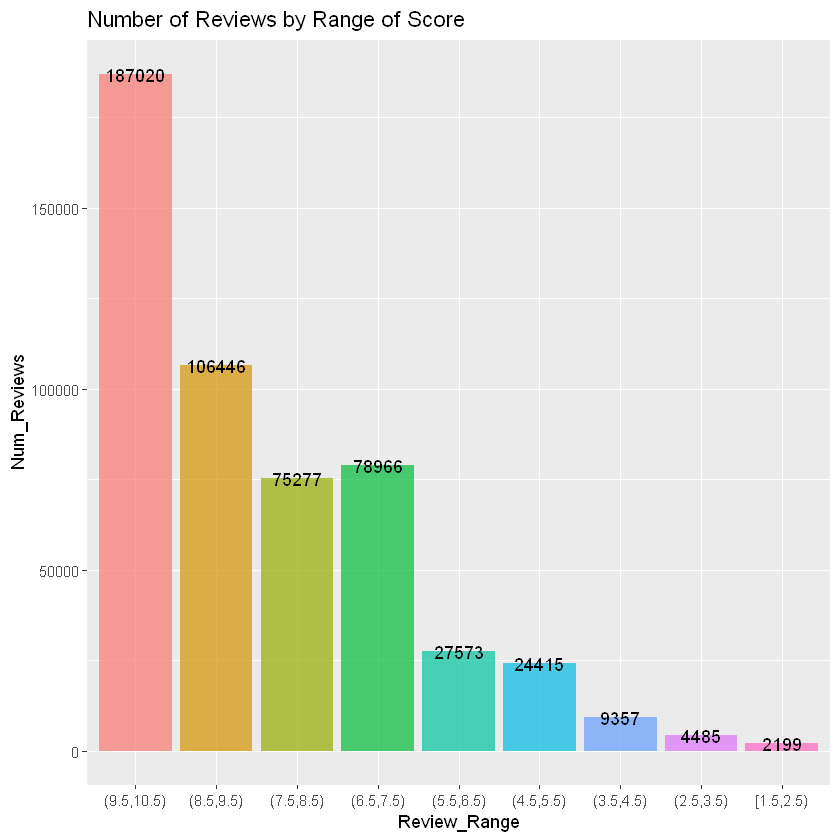

In [30]:
grid.draw(g1)

In [31]:
p2 <- ggplot(review_range, aes(
    x = Review_Range,
    y = Pos_Word_Rate,
    fill = Review_Range
)) +
    geom_bar(stat = "identity", alpha = 0.7) +
    geom_text(label = review_range$Pos_Word_Rate, nudge_y = 0.2) +
    ggtitle(label = "Percent Positive Words by Range of Score") +
    labs(xlab("Review Range"), ylab("Percent(%) Positive Words")) +
    theme(legend.position = "bottom")

g2 <- ggplotGrob(p2)

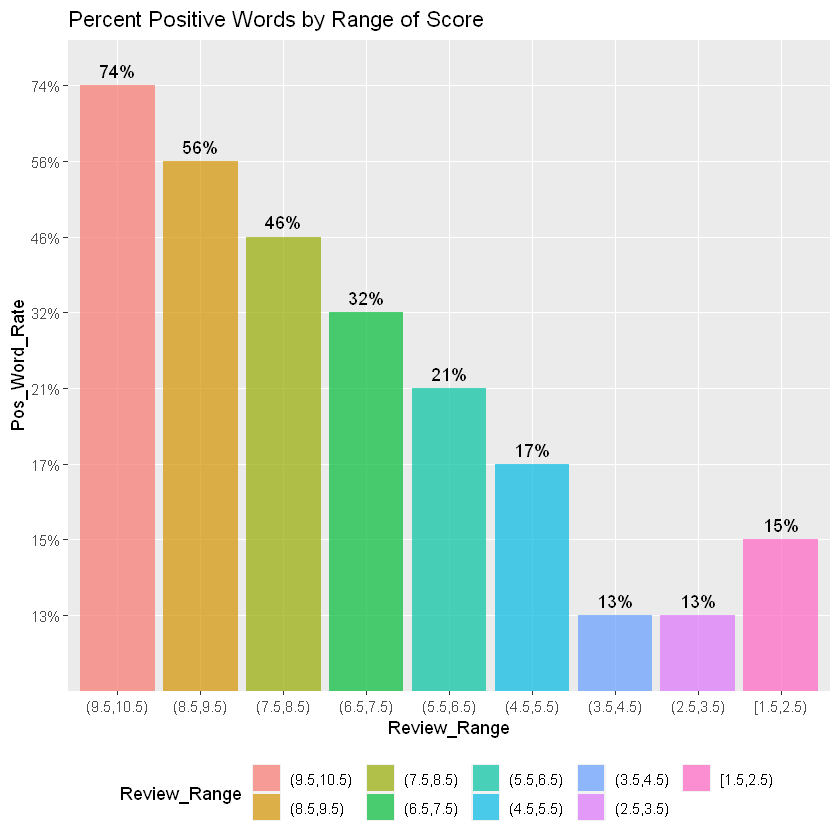

In [32]:
grid.draw(g2)

In [33]:
p3 <- ggplot(review_range, aes(
    x = Review_Range,
    y = Avg_Words_Per_Review,
    fill = Review_Range
)) +
    geom_bar(stat = "identity", alpha = 0.7) +
    geom_text(label = review_range$Avg_Words_Per_Review, nudge_y = 0.2) +
    ggtitle(label = "Average Words per Review by Range of Score") +
    labs(xlab("Review Range"), ylab("Avg. Words per Review")) +
    theme(legend.position = "off")

g3 <- ggplotGrob(p3)


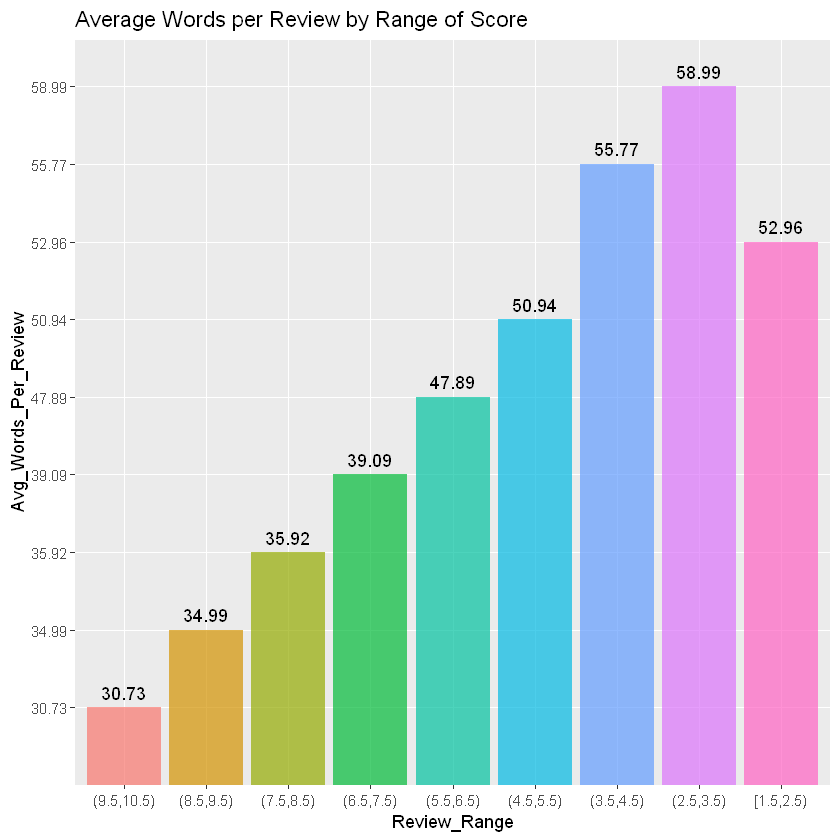

In [34]:
grid.draw(g3)

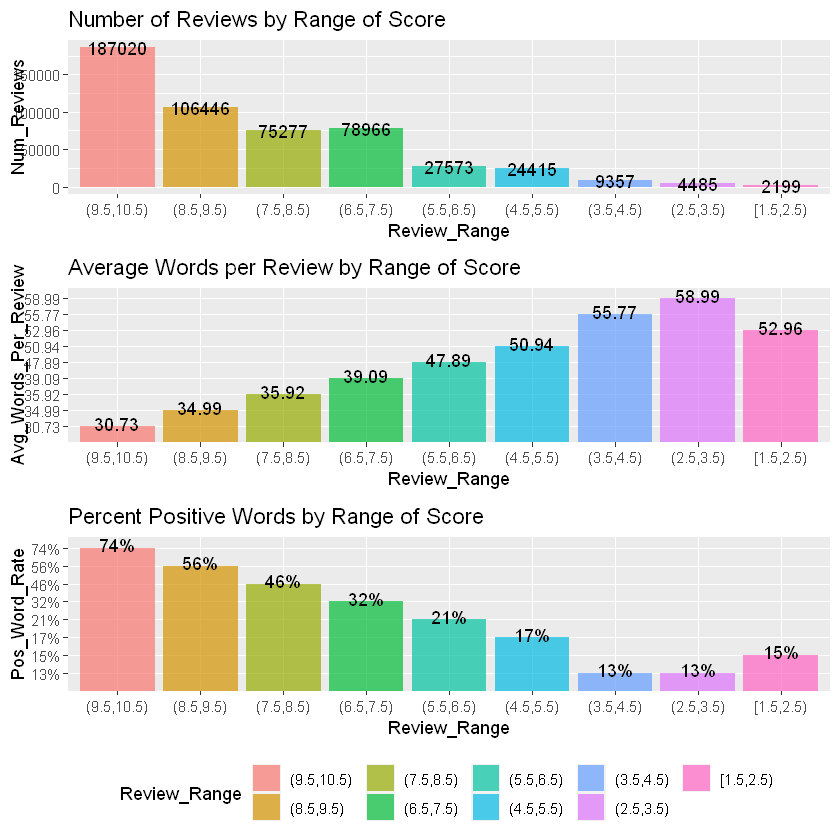

In [35]:
grid.draw(rbind(g1, g3, g2, size = "last"))